# Compute optimal individual parameters for AC metric

In [1]:
from zurich_move_data_extraction import *
from activity_count_function import *
from utilities import *
from gm_function import *
from individual_analysis_ac_functions import *
from extract_mask_from_video import *
from individual_analysis_fs_functions import *
from group_analysis_functions import *

C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#CHANGE VALUES HERE#
# H for Healthy and S for Stroke 
participant_id = 'H005'
participant_group = 'H'

In [3]:
#PATH# 
initial_path = '../CreateStudy'
participant_path = os.path.join(initial_path, participant_id)
print(participant_path)

../CreateStudy\H005


In [4]:
# Extract dataset from the participant JSON file 
participant_data = load_participant_json(participant_id, initial_path)
# Get the correct handiness 
# For stroke, dominant hand = non affected hand 
dominant_hand = get_dominant_hand(participant_data)

In [5]:
# Get the data from IMU csv files 
ndh_data, chest_data, dh_data, GT_mask_25Hz_NDH, GT_mask_25Hz_DH = get_data(participant_path, dominant_hand)
# Ensure the array sizes consistency between masks and IMU data
print (len(GT_mask_25Hz_NDH)*2, len(ndh_data))

35368 35368


In [6]:
# Get useful variables
sampling_freq = 50
acc_ndh = ndh_data[['acc_x', 'acc_y', 'acc_z']]
acc_dh = dh_data[['acc_x', 'acc_y', 'acc_z']]
gyro_ndh = ndh_data[['gyro_x', 'gyro_y', 'gyro_z']]
gyro_dh = dh_data[['gyro_x', 'gyro_y', 'gyro_z']]
mag_ndh = ndh_data[['magneto_x', 'magneto_y', 'magneto_z']]
quat_sensor_ndh = ndh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
quat_sensor_dh = dh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
frequency_AC = 1 # Hz 
frequency_GM = 2 # Hz
FPS_mask = 25 # Hz
frequency_euler_angles = 50 # Hz 

In [7]:
#Compute Actigraph Activity Count using Brond calculation
# raw code here: https://github.com/jbrond/ActigraphCounts/blob/master/R/Python_G_to_sec.py
count_brond_ndh, processed_data_ndh = get_counts_brond(ndh_data)
count_brond_dh, processed_data_dh = get_counts_brond(dh_data)
AC_ndh = np.array(count_brond_ndh['AC Brond'])
AC_dh = np.array(count_brond_dh['AC Brond'])

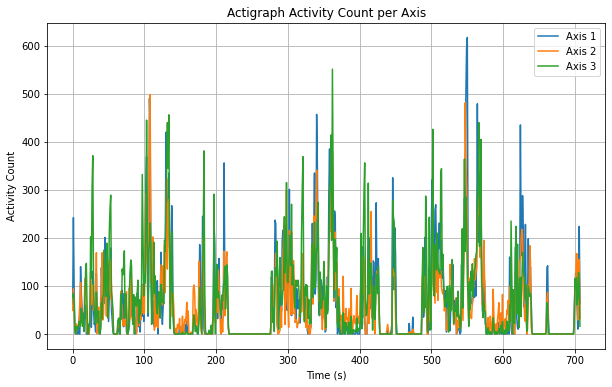

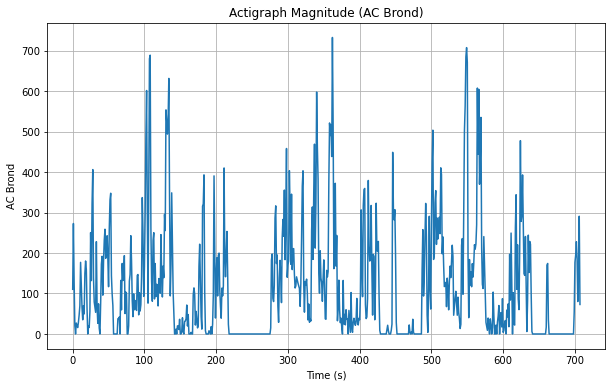

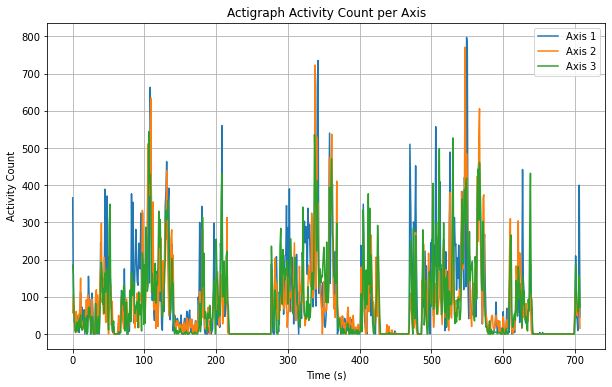

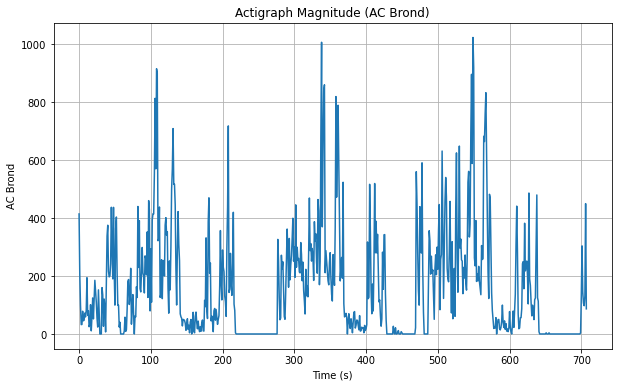

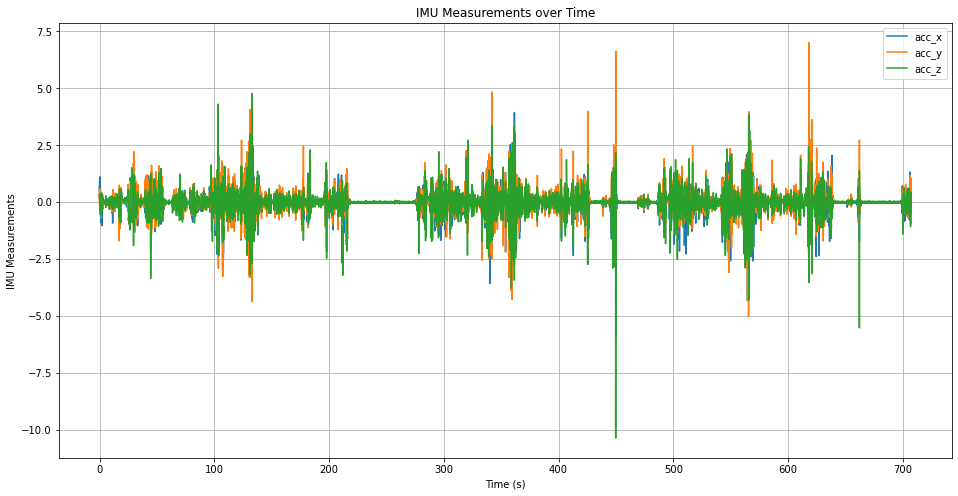

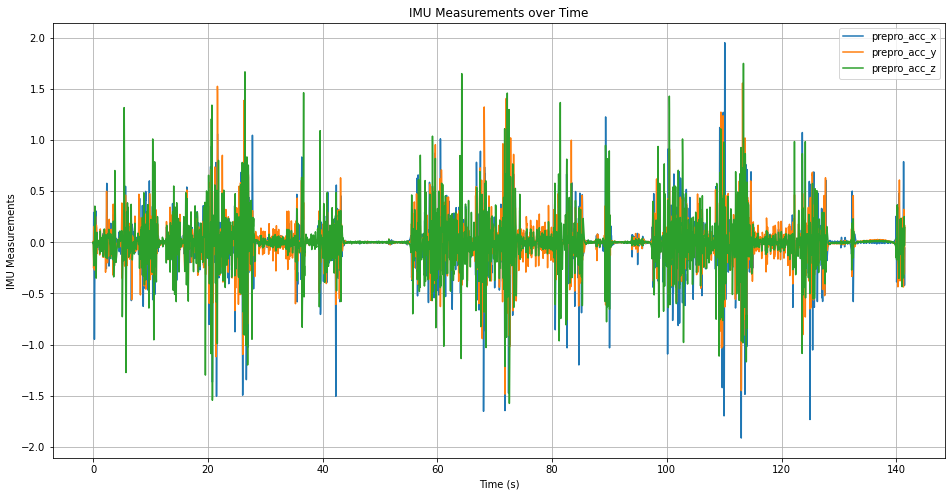

In [8]:
plot_actigraph_count(count_brond_ndh), plot_actigraph_count(count_brond_dh)
plot_raw_data(acc_ndh, sampling_freq)
plot_raw_data(processed_data_ndh, sampling_freq)

In [9]:
# MASK Resampling #

In [10]:
# Replace all WBM (whole-body movements) by NF movements inside the GT mask @ 25 Hz 
# Could be changed in the future (e.g. remove all WBM movements)
GT_mask_NDH_25Hz = replace_wbm_with_nf(GT_mask_25Hz_NDH).ravel()
GT_mask_DH_25Hz = replace_wbm_with_nf(GT_mask_25Hz_DH).ravel()

In [11]:
# Downsample GT masks to be used later on for AC (1Hz) and GM (2Hz) computation
GT_mask_NDH_1Hz = resample_mask(GT_mask_NDH_25Hz, FPS_mask, frequency_AC)
GT_mask_DH_1Hz = resample_mask(GT_mask_DH_25Hz, FPS_mask, frequency_AC)
GT_mask_NDH_2Hz = resample_mask(GT_mask_NDH_25Hz, FPS_mask, frequency_GM)
GT_mask_DH_2Hz = resample_mask(GT_mask_DH_25Hz, FPS_mask, frequency_GM)

# Ensure GT Mask @ 1 hZ have same size as the Brond AC values 
GT_mask_NDH_1Hz, AC_ndh = remove_extra_elements(GT_mask_NDH_1Hz, AC_ndh)
GT_mask_DH_1Hz, AC_dh = remove_extra_elements(GT_mask_DH_1Hz, AC_dh)

In [12]:
# Upsample GT masks to be used lated for the GM algorithm computation (50 Hz)
GT_mask_NDH_50Hz = resample_mask(GT_mask_NDH_25Hz, FPS_mask, frequency_euler_angles)
GT_mask_DH_50Hz = resample_mask(GT_mask_DH_25Hz, FPS_mask, frequency_euler_angles)

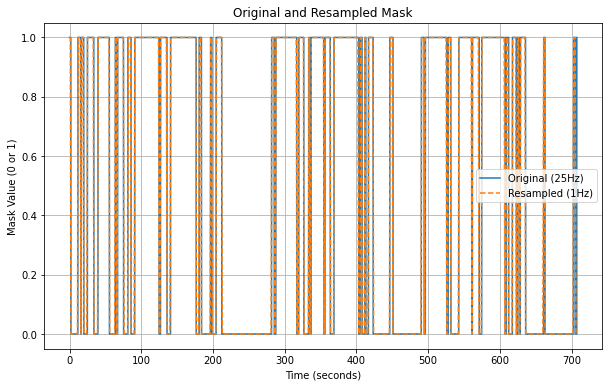

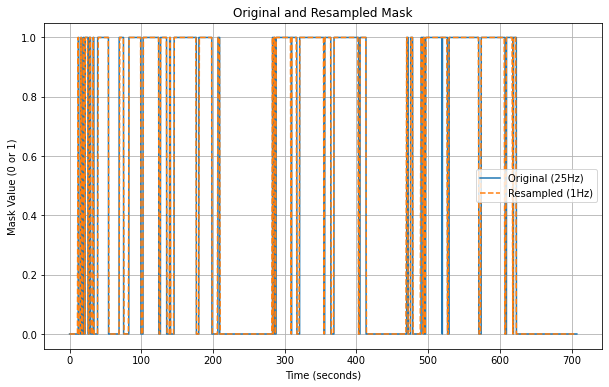

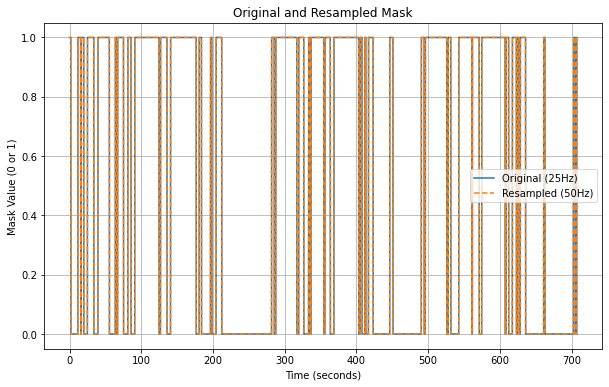

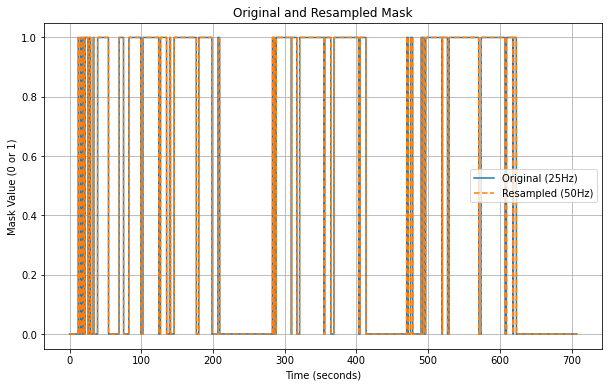

In [13]:
# Plots to ensure the downsampling was correctly done
plot_resampled_arrays(GT_mask_NDH_25Hz, FPS_mask, GT_mask_NDH_1Hz, frequency_AC)
plot_resampled_arrays(GT_mask_DH_25Hz, FPS_mask, GT_mask_DH_1Hz, frequency_AC)
plot_resampled_arrays(GT_mask_NDH_25Hz, FPS_mask, GT_mask_NDH_50Hz, frequency_euler_angles)
plot_resampled_arrays(GT_mask_DH_25Hz, FPS_mask, GT_mask_DH_50Hz, frequency_euler_angles)

In [14]:
# Update the participant dataset file with new arrays of usefull data  
# Add Brond AC
add_attributes_to_participant(participant_data, AC_NDH = AC_ndh, AC_DH = AC_dh)
# Add mask @ 1 Hz, @ 2 Hz, @ 25 Hz and  @ 50 Hz
add_attributes_to_participant(participant_data, GT_mask_NDH_1Hz = GT_mask_NDH_1Hz, GT_mask_DH_1Hz = GT_mask_DH_1Hz, 
                             GT_mask_NDH_2Hz = GT_mask_NDH_2Hz, GT_mask_DH_2Hz = GT_mask_DH_2Hz, 
                             GT_mask_NDH_25Hz = GT_mask_NDH_25Hz, GT_mask_DH_25Hz = GT_mask_DH_25Hz,
                             GT_mask_NDH_50Hz = GT_mask_NDH_50Hz, GT_mask_DH_50Hz = GT_mask_DH_50Hz)

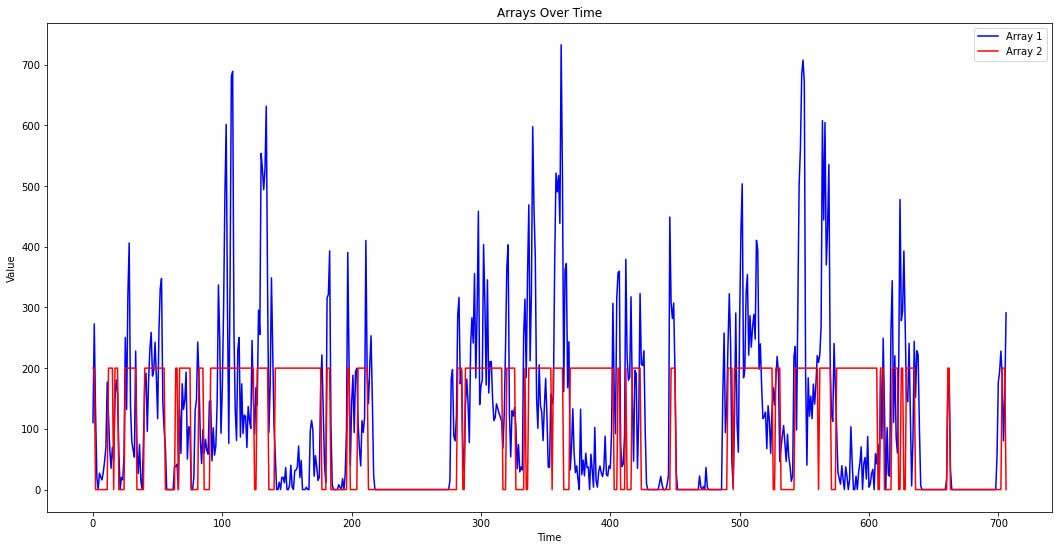

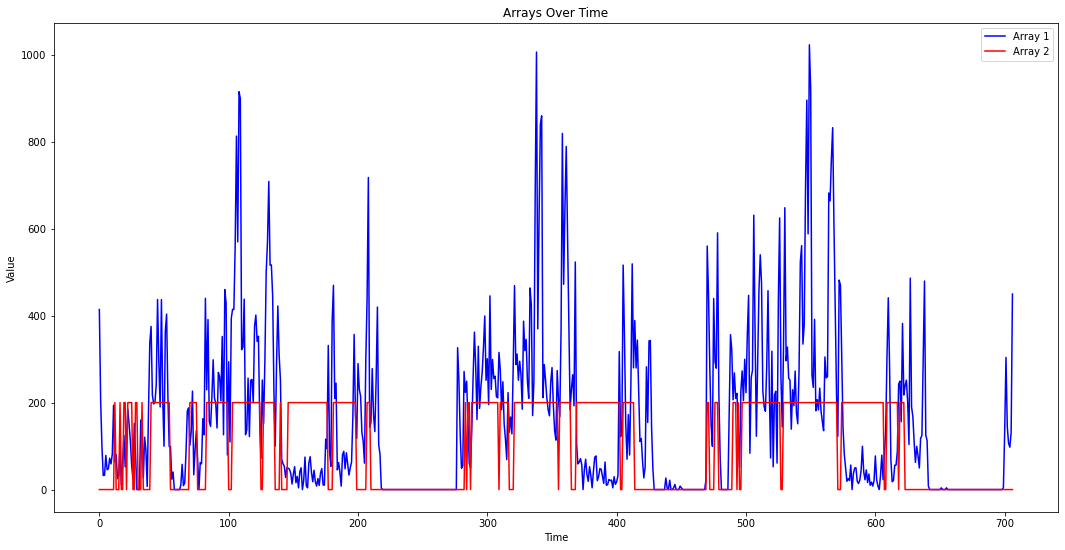

In [15]:
# Plot to visualize AC and GT superposed
plot_superposition(AC_ndh, 200*GT_mask_NDH_1Hz)
plot_superposition(AC_dh, 200*GT_mask_DH_1Hz)

In [16]:
## INDIVIDUAL OPTIMIZATION PART ##

In [17]:
# Perform k-fold cross-validation for the left wrist data
# Return average optimal AC threshold and average evaluation metrics on this optimal parameter when tested against GT
eval_metrics_opt_ndh, opt_threshold_ndh = k_fold_cross_validation(AC_ndh, GT_mask_NDH_1Hz, optimal=True)
# Same but for conventional fixed threshold 
eval_metrics_conv_ndh, conv_threshold_ndh = k_fold_cross_validation(AC_ndh, GT_mask_NDH_1Hz, optimal=False)

Iteration 1/5
AUC: 0.7936968145191655
Optimal Threshold: 30.00
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 2/5
AUC: 0.8070364488808227
Optimal Threshold: 15.00
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 3/5
AUC: 0.7856891325946701
Optimal Threshold: 21.00
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 4/5
AUC: 0.7866169372531813
Optimal Threshold: 29.00
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 5/5
AUC: 0.7904161664665867
Optimal Threshold: 30.00
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 1/5
Using conventional threshold
Iteration 2/5
Using conventional threshold
Iteration 3/5
Using conventional threshold
Iteration 4/5
Using conventional threshold
Iteration 5/5
Using conventional threshold


In [18]:
# Perform k-fold cross-validation for the right wrist data
# Return average optimal AC threshold and average evaluation metrics on this optimal parameter when tested against GT
eval_metrics_opt_dh, opt_threshold_dh = k_fold_cross_validation(AC_dh, GT_mask_DH_1Hz, optimal=True)
# Same but for conventional fixed threshold
eval_metrics_conv_dh, conv_threshold_dh = k_fold_cross_validation(AC_dh, GT_mask_DH_1Hz, optimal=False)

Iteration 1/5
AUC: 0.7708919421280016
Optimal Threshold: 8.00
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 2/5
AUC: 0.7829466152722142
Optimal Threshold: 4.00
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 3/5
AUC: 0.7806962383509615
Optimal Threshold: 4.00
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 4/5
AUC: 0.7828339928396457
Optimal Threshold: 4.00
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 5/5
AUC: 0.7925350155833427
Optimal Threshold: 12.00
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 1/5
Using conventional threshold
Iteration 2/5
Using conventional threshold
Iteration 3/5
Using conventional threshold
Iteration 4/5
Using conventional threshold
Iteration 5/5
Using conventional threshold


In [19]:
# Bilaterage usage of the UL (different conventional threshold) using logical AND (both UL)
eval_metrics_opt_bil = k_fold_cross_validation_bilateral(AC_ndh, AC_dh, GT_mask_NDH_1Hz,
                                                         GT_mask_DH_1Hz, opt_threshold_ndh,
                                                         opt_threshold_dh, optimal=True)
eval_metrics_conv_bil = k_fold_cross_validation_bilateral(AC_ndh, AC_dh, GT_mask_NDH_1Hz,
                                                          GT_mask_DH_1Hz, opt_threshold_ndh,
                                                          opt_threshold_dh, optimal=False)

Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5
Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5


In [20]:
# Optimal AC thresholds for this participant 
print(opt_threshold_ndh, opt_threshold_dh)

25.0 6.4


In [21]:
# Create a structure to save all the evaluation metrics 
metrics_dictionary_AC = create_metrics_dictionary(eval_metrics_conv_ndh, eval_metrics_conv_dh,
                                               eval_metrics_conv_bil, eval_metrics_opt_ndh,
                                               eval_metrics_opt_dh, eval_metrics_opt_bil)

In [22]:
metrics_dictionary_AC

{'OT_ndh_Sensitivity': 86.75297224869168,
 'OT_ndh_Specificity': 59.72212014575327,
 'OT_ndh_Accuracy': 73.98261911896914,
 'OT_ndh_PPV': 70.93898083588806,
 'OT_ndh_NPV': 79.78145847286052,
 'OT_dh_Sensitivity': 96.10098193431527,
 'OT_dh_Specificity': 50.42819535130366,
 'OT_dh_Accuracy': 74.81869943062631,
 'OT_dh_PPV': 68.91293112827768,
 'OT_dh_NPV': 91.77548601232812,
 'OT_bilateral_Sensitivity': 83.05755585866828,
 'OT_bilateral_Specificity': 55.73635037132217,
 'OT_bilateral_Accuracy': 67.89431625212266,
 'OT_bilateral_PPV': 59.46586844610393,
 'OT_bilateral_NPV': 80.93541568968983,
 'CT_ndh_Sensitivity': 94.5827365614717,
 'CT_ndh_Specificity': 52.15748183800209,
 'CT_ndh_Accuracy': 74.68584556987314,
 'CT_ndh_PPV': 69.02042200392307,
 'CT_ndh_NPV': 89.962521625225,
 'CT_dh_Sensitivity': 98.63052338052337,
 'CT_dh_Specificity': 48.415179489723265,
 'CT_dh_Accuracy': 75.24423134551992,
 'CT_dh_PPV': 68.56695282315937,
 'CT_dh_NPV': 97.0952380952381,
 'CT_bilateral_Sensitivity':

In [23]:
# Add metrics for AC threshold evaluation to the JSON file 
add_attributes_to_participant(participant_data, metrics_dictionary_AC = metrics_dictionary_AC) 
# Add optimal AC parameter to the JSON file 
add_attributes_to_participant(participant_data, optimal_AC_NDH = opt_threshold_ndh, optimal_AC_DH = opt_threshold_dh) 

In [24]:
# Laterality metrics # 
# Main author: A Method for Quantifying Upper Limb Performance in Daily Life Using Accelerometers - PMC
# Lang et al. 2017

In [25]:
# Bilateral Magnitude 
bilateral_magnitude = compute_bilateral_magnitude(AC_ndh, AC_dh)

In [26]:
# Magnitude Ratio
magnitude_ratio = get_magnitude_ratio(AC_ndh, AC_dh)

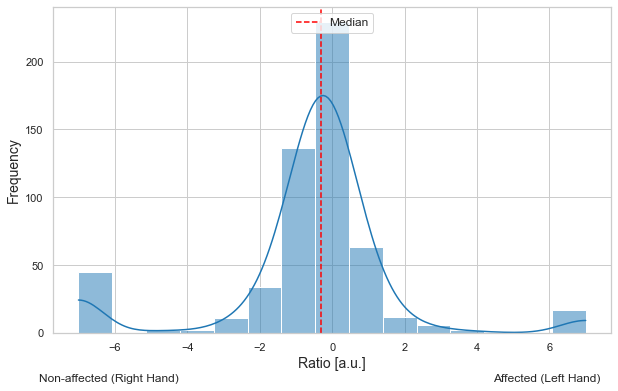

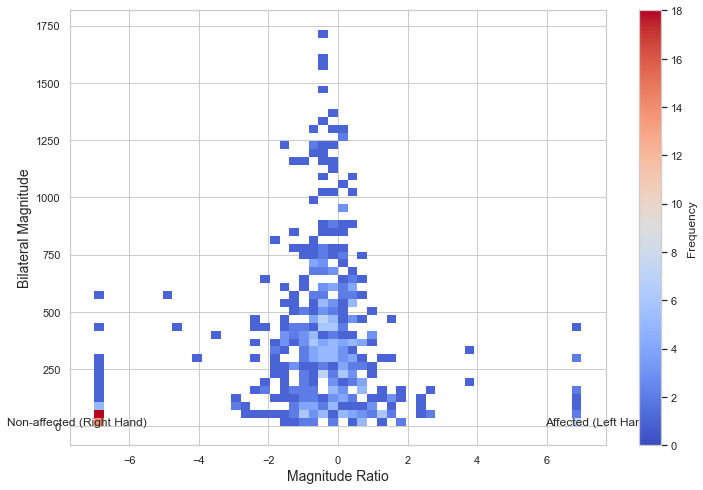

In [27]:
# Pots to visualize UL usage 
plot_distribution_ratio(magnitude_ratio, non_affected_hand = dominant_hand, saving_path = None)
plot_density(bilateral_magnitude, magnitude_ratio, non_affected_hand = dominant_hand, saving_path = None)

In [28]:
# Save the JSON file with the new fields 
save_to_json(participant_data, participant_path)

Data saved to: ../CreateStudy\H005\H005.json
